In [ ]:
from __future__ import annotations
import os
os.chdir('/home/elopez/RL-Project/DKONG')
import socket
HOSTNAME = socket.gethostname()

if HOSTNAME == "cudahpc16":
	# idk who set up this cluster but without this the gpu is not detected
	os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
	os.environ["CUDA_VISIBLE_DEVICES"] = "6"
	os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import argparse
import random
from collections import deque
from pathlib import Path
from typing import Deque, Dict, List, Callable

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

from environment.env import make_env
from models.base import CustomCNN
from _logging import load_config, load_pretrain_config

In [3]:
config = load_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
from environment.wrappers import ResizeObservation

env = gym.make("ALE/DonkeyKong-v5", render_mode="rgb_array")
env = ResizeObservation(env, config)
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Observation space: Box(0, 255, (128, 128, 3), uint8)
Action space: Discrete(18)


Observation shape: (128, 128, 3)


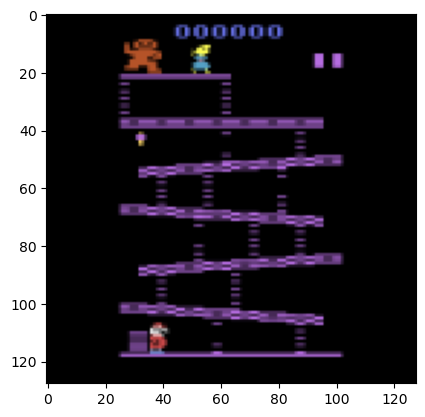

In [5]:
import matplotlib.pyplot as plt

# plot example obs
obs, _ = env.reset()
print(f"Observation shape: {obs.shape}")
plt.imshow(obs)
plt.show()

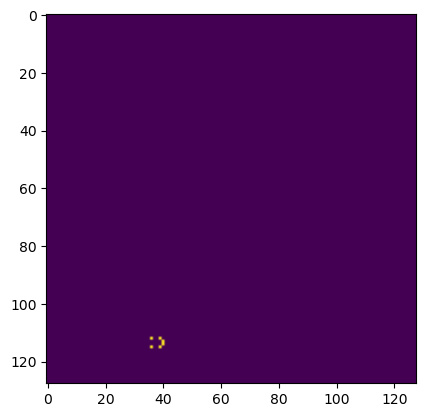

In [6]:
# detect the most "reddish" color in the screen
# Compute "redness" as R - max(G,B)
redness = obs[:, :, 0].astype(np.int16) - np.maximum(obs[:, :, 1], obs[:, :, 2]).astype(np.int16)
# Find the pixel(s) with the maximum redness
max_redness = np.max(redness)
most_reddish = (redness == max_redness)
# Plot the pixels that are the most reddish
plt.imshow(most_reddish)
plt.show()

Center of mass: [113.5         38.33333333]


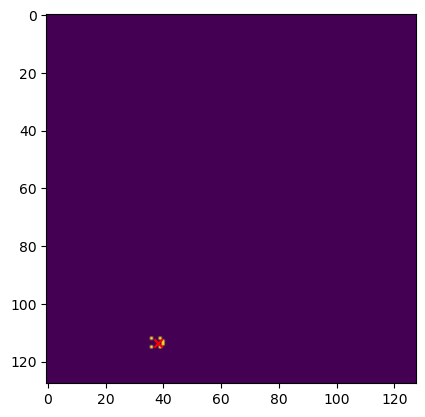

In [7]:
# take center of mass of the most reddish pixels
center_of_mass = np.argwhere(most_reddish)
center_of_mass = np.mean(center_of_mass, axis=0)
print(f"Center of mass: {center_of_mass}")
# plot center of mass
plt.imshow(most_reddish)
plt.scatter(center_of_mass[1], center_of_mass[0], color="red", marker="x")
plt.show()

In [ ]:
# 